<a href="https://colab.research.google.com/github/srilalithaveerubhotla/CNN-BASICS/blob/master/vgg16_pytorch_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 pytorch scratch code on cifar100 dataset

In [0]:
# importing libraries
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


In [0]:
# downloading CIFAR100 dataset
# transforming the PIL Image to tensors
train = torchvision.datasets.CIFAR100(root = "./data", train=True, download = True, transform = transforms.ToTensor())

#loading the training data from trainset
trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle = True)

Files already downloaded and verified


## VGG16 Architecture

In [0]:
# Reference: https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/vgg.py

cfg = {
    'A' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_class=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
    
        return output

def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]
        
        layers += [nn.ReLU(inplace=True)]
        input_channel = l
    
    return nn.Sequential(*layers)


def vgg16_bn():
    return VGG(make_layers(cfg['A'], batch_norm=True))


In [0]:
net = vgg16_bn()
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
# view the training data

#iterating into the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# view the shape of 4 images
print(images.shape) 

# view the shape of 1 image
print(images[1].shape) 

# view the label of the first image
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
67


<class 'torch.Tensor'>
(3, 32, 32)
(32, 32, 3)


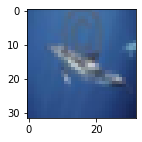

In [0]:
#taking the first image from batch of 4 images

img = images[0]
print(type(img))

#convert the tensor to numpy for displaying the image
npimg = img.numpy()
print(npimg.shape)

#for displaying the image, shape of the image should be height * width * channels
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

plt.figure(figsize = (2,2))
plt.imshow(np.squeeze(npimg))
plt.show()

In [0]:
# Training VGG16 

#increase the batch size
batch_size = 128

#download the data again and set the train, test loader with different batch size
train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#reference a variable to gpu card to make the training faster
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#create the model object and move it to GPU
net = vgg16_bn().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [0]:
# method to calculate the accuracy on a gpu
def evaluate(dataloader):
    total, correct = 0, 0
    
    #keeping the network in evaluation mode
    net.eval()
    for data in dataloader:
        inputs, labels = data
        #moving the inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/1, Test acc: 3.29, Train acc: 3.44


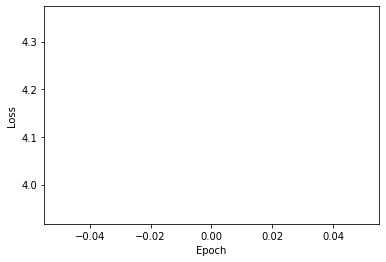

CPU times: user 2min 18s, sys: 1min 20s, total: 3min 38s
Wall time: 3min 38s


In [0]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 1

for epoch in range(max_epochs):
    #iterate through all the batches in each epoch
    for i, data in enumerate(trainloader, 0):
        
        #keeping the network in training mode
        net.train()
    
        inputs, labels = data
        #moving the input and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        #clear the gradients
        opt.zero_grad()
        #forward pass
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        #backward pass
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluate(testloader), evaluate(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()